In [1]:
from pyspark import SparkContext
from pyspark.streaming import StreamingContext
from pyspark.sql import SQLContext
from pyspark.sql.functions import desc

In [2]:
sc = SparkContext(appName="TwitterAnalysis")
sc.setLogLevel("ERROR")
ssc = StreamingContext(sc, 10)

In [3]:
sqlContext = SQLContext(sc)
#ssc.checkpoint( "file:///home/hadoop/lab/programs/trends/checkpoint")

In [4]:
socket_stream = ssc.socketTextStream("172.31.38.183", 1212)

In [5]:
lines = socket_stream.window( 20 )

In [6]:
from collections import namedtuple #function for creating tuple subclasses with named fields
fields = ("Hash", "count" )
Tweet = namedtuple( 'Tweet', fields )

In [7]:
( lines.flatMap( lambda text: text.split( " " ) )
  .filter( lambda word: word.lower().startswith("#") )
  .map( lambda word: ( word.lower(), 1 ) )
  .reduceByKey( lambda a, b: a + b )
  .map( lambda rec: Tweet( rec[0], rec[1] ) )
  .foreachRDD( lambda rdd: rdd.toDF().sort( desc("count") )
              .limit(10).registerTempTable("tweets") ) )

In [8]:
sqlContext

In [9]:
ssc.start()

In [10]:
import matplotlib.pyplot as plt
import seaborn as sn

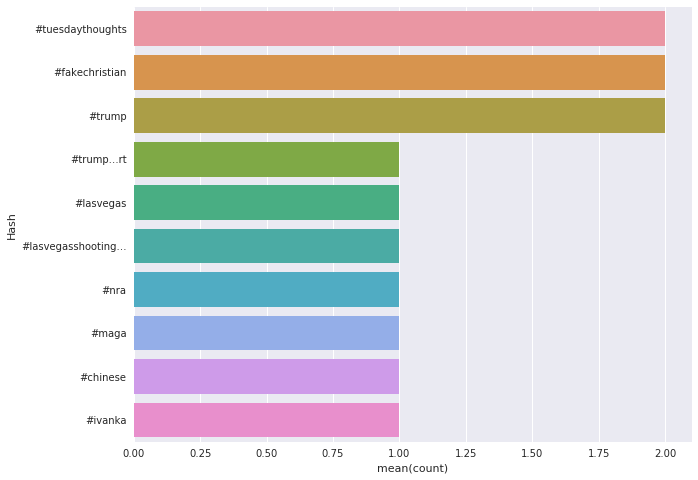

In [11]:
import time
from IPython import display


count = 0
while count < 10:
  time.sleep( 20 )
  top_10_topics = sqlContext.sql( 'Select Hash, count from tweets' )
  top_10_topics_df = top_10_topics.toPandas()
  display.clear_output(wait=True)
  sn.plt.figure( figsize = ( 10, 8 ) )
  sn.barplot( x="count", y="Hash", data=top_10_topics_df)
  sn.plt.show()
  count = count + 1

In [12]:
#ssc.stop()